# FAST FOOD MARKETING CAMPAIGN A/B TEST

The data is from Kaggle, IBM Watson Analytics Marketing Campaign

- A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
- Evaluate A/B testing results and decide which marketing strategy works the best

## Target Metric: 

### SalesInThousands
- The total weekly sales (in thousands of dollars) recorded for each promotion group during the test.

### Null Hypotheses

- H₀ (Kruskal-Wallis Test): There is no significant difference in sales between the three promotions.

- H₀ (Mann-Whitney U Tests for Pairwise Comparisons): The median sales for each pair of promotions are equal.

### Why SalesInThousands is a Good Target Metric

1. Directly Linked to Business Goals:
    - Sales are a key measure of the effectiveness of any marketing campaign.
    - Higher sales indicate better customer engagement and conversion rates.

2. Measurable and Comparable:
    - Weekly sales are quantifiable and allow direct comparisons between the different promotions

3. Relevant to Decision-Making:
    - By identifying the promotion that drives the highest sales, the business can focus on scaling the most effective campaign.





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from scipy.stats import chi2_contingency


## Loading dataset

In [2]:
file_path = "WA_Marketing-Campaign.csv"
df = pd.read_csv(file_path)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB
None


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## Sample size and Variant Proportions

In [3]:
sample_size = df["Promotion"].value_counts()
variant_proportions = df["Promotion"].value_counts(normalize=True)
print("Sample Size per Promotion:")
print(sample_size)
print("\nVariant Proportions per Promotion:")
print(variant_proportions)

Sample Size per Promotion:
Promotion
3    188
2    188
1    172
Name: count, dtype: int64

Variant Proportions per Promotion:
Promotion
3    0.343066
2    0.343066
1    0.313869
Name: proportion, dtype: float64


## EDA

### Checking for missing values and summary statistics

In [4]:
print(df.isnull().sum())
print(df.describe())

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64
         MarketID  LocationID  AgeOfStore   Promotion        week  \
count  548.000000  548.000000  548.000000  548.000000  548.000000   
mean     5.715328  479.656934    8.503650    2.029197    2.500000   
std      2.877001  287.973679    6.638345    0.810729    1.119055   
min      1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000  216.000000    4.000000    1.000000    1.750000   
50%      6.000000  504.000000    7.000000    2.000000    2.500000   
75%      8.000000  708.000000   12.000000    3.000000    3.250000   
max     10.000000  920.000000   28.000000    3.000000    4.000000   

       SalesInThousands  
count        548.000000  
mean          53.466204  
std           16.755216  
min           17.340000  
25%           42.545000  
50%           50.200000  
75%           60.477500  
max

### Sales EDA

#### Sales Distribution

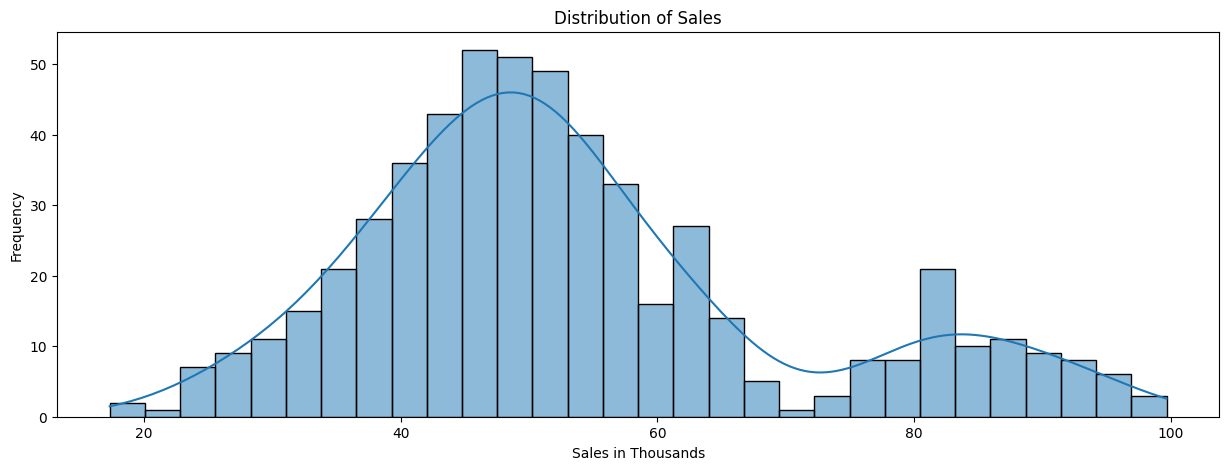

In [5]:
plt.figure(figsize=(15, 5))
sns.histplot(df["SalesInThousands"], bins=30, kde=True)
plt.xlabel("Sales in Thousands")
plt.ylabel("Frequency")
plt.title("Distribution of Sales")
plt.show()

The distribution is right-skewed (positively skewed), meaning there are some stores with significantly higher sales compared to the majority.
There are multiple peaks, suggesting the presence of distinct clusters or multiple underlying distributions.

Since the distribution is not perfectly normal and has outliers, parametric tests (like t-tests) may not be appropriate.
Non-parametric tests like Kruskal-Wallis or Mann-Whitney U might be better suited to compare sales between promotions.

#### Sales distribution by promotion

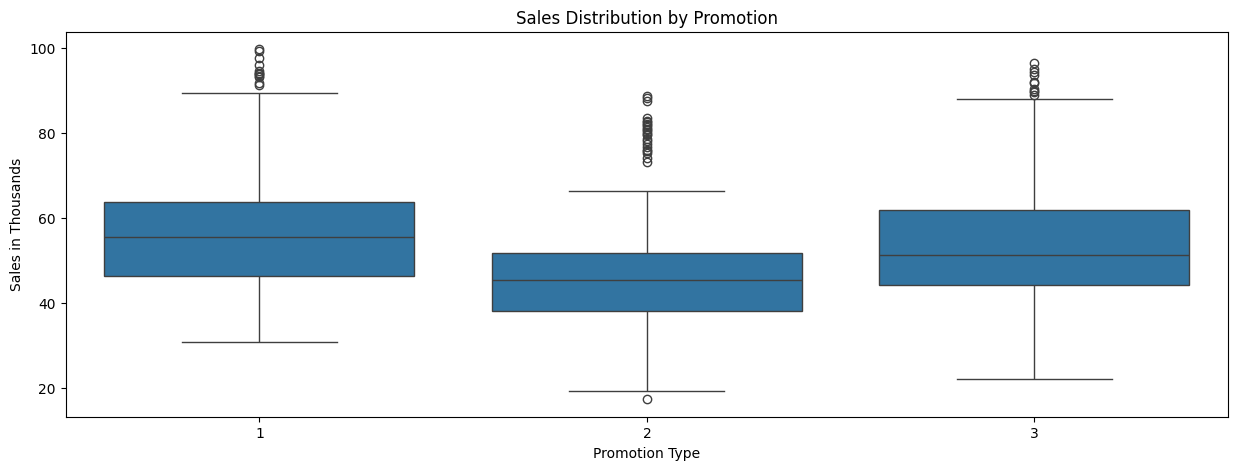

In [6]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="Promotion", y="SalesInThousands", data=df)
plt.xlabel("Promotion Type")
plt.ylabel("Sales in Thousands")
plt.title("Sales Distribution by Promotion")
plt.show()

Promotion 1 and Promotion 3 have a wider spread compared to Promotion 2.
Promotion 2’s interquartile range (IQR) is smaller, meaning sales under this promotion are more consistent but lower overall.
Promotion 1 and Promotion 3 have a similar sales range, but Promotion 3 might have slightly higher variability

All promotions have outliers above 80K, with Promotion 1 and Promotion 3 having more extreme outliers.
These outliers represent stores that performed exceptionally well under certain promotions, and further analysis might be needed to understand why

#### Sales distribution by Market Size

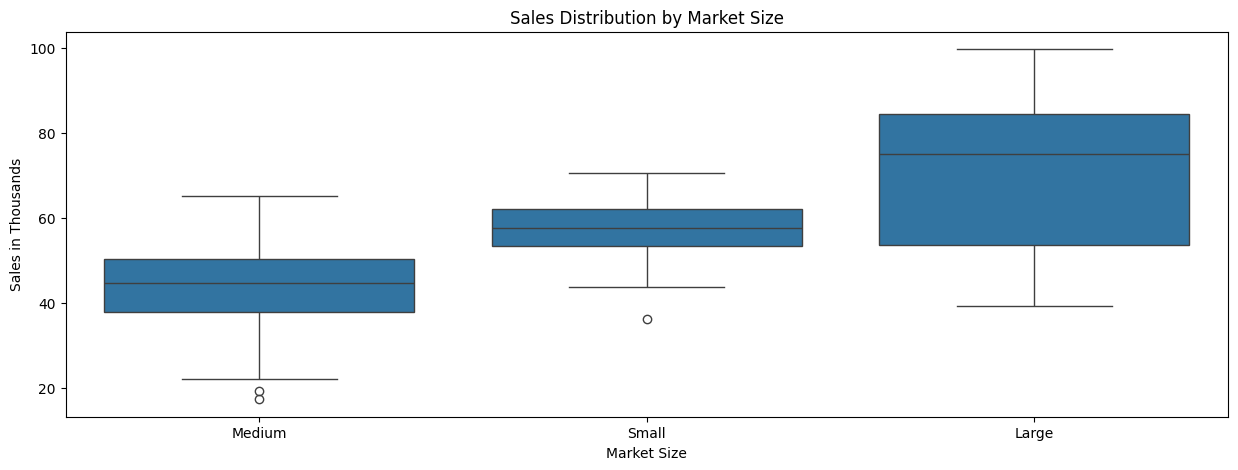

In [7]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="MarketSize", y="SalesInThousands", data=df)
plt.xlabel("Market Size")
plt.ylabel("Sales in Thousands")
plt.title("Sales Distribution by Market Size")
plt.show()


Large markets have the widest range of sales values, meaning sales performance in these markets varies significantly across stores.
Small markets have the least variability, indicating more consistent sales.
Medium markets have lower median sales and a tighter interquartile range, showing relatively stable but lower revenue.

The effectiveness of promotions may be influenced by market size.
If promotions are disproportionately allocated to a particular market size, the test results could be biased.

#### Store age vs Sales

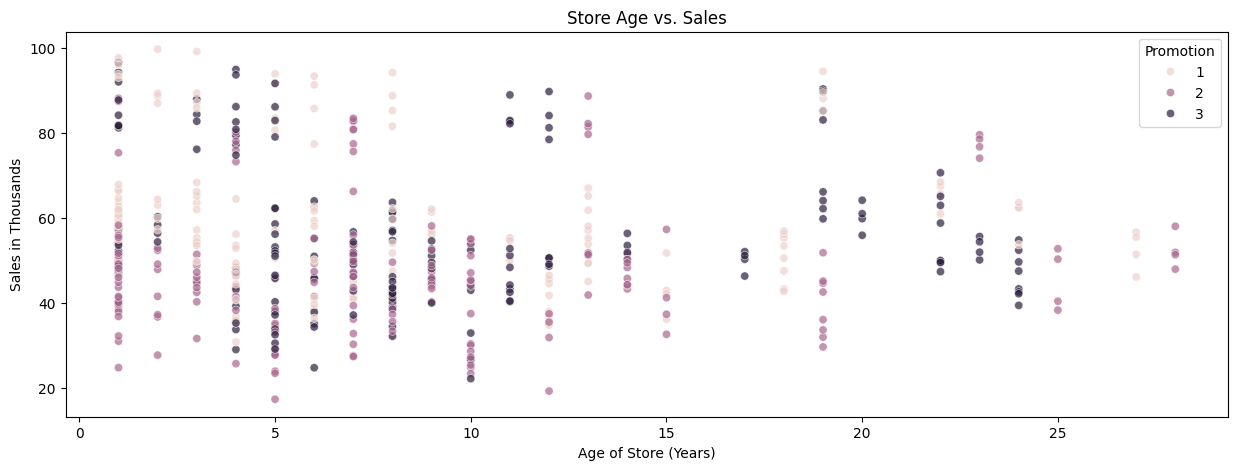

In [8]:
plt.figure(figsize=(15, 5))
sns.scatterplot(x="AgeOfStore", y="SalesInThousands", hue="Promotion", data=df, alpha=0.7)
plt.xlabel("Age of Store (Years)")
plt.ylabel("Sales in Thousands")
plt.title("Store Age vs. Sales")
plt.show()

There doesn’t appear to be a strong upward or downward trend, meaning store age does not have a clear direct correlation with sales.

Promotions are evenly distributed across store ages, meaning there is no clear bias in how promotions were assigned.
However, some promotions may be more effective in newer stores, as indicated by higher sales outliers.

#### Sales by Market Size and Store Age

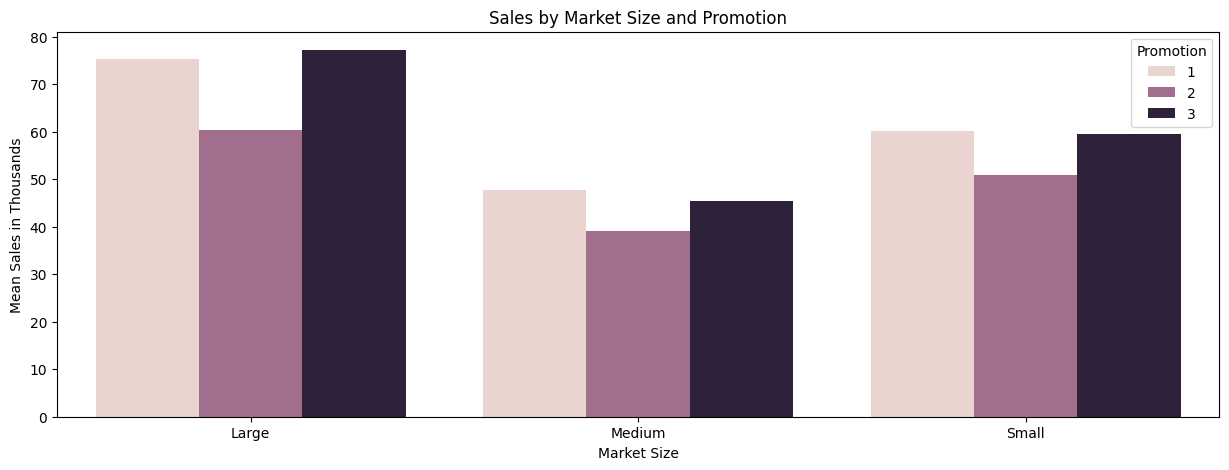

In [9]:
df_market_promo = df.groupby(["MarketSize", "Promotion"], as_index=False)["SalesInThousands"].mean()
df_store_promo = df.groupby(["AgeOfStore", "Promotion"], as_index=False)["SalesInThousands"].mean()
df["StoreAgeGroup"] = pd.cut(df["AgeOfStore"], bins=[0, 5, 10, 15, 20, 30], labels=["0-5", "6-10", "11-15", "16-20", "21+"])


plt.figure(figsize=(15, 5))
sns.barplot(x="MarketSize", y="SalesInThousands", hue="Promotion", data=df_market_promo)
plt.xlabel("Market Size")
plt.ylabel("Mean Sales in Thousands")
plt.title("Sales by Market Size and Promotion")
plt.show()

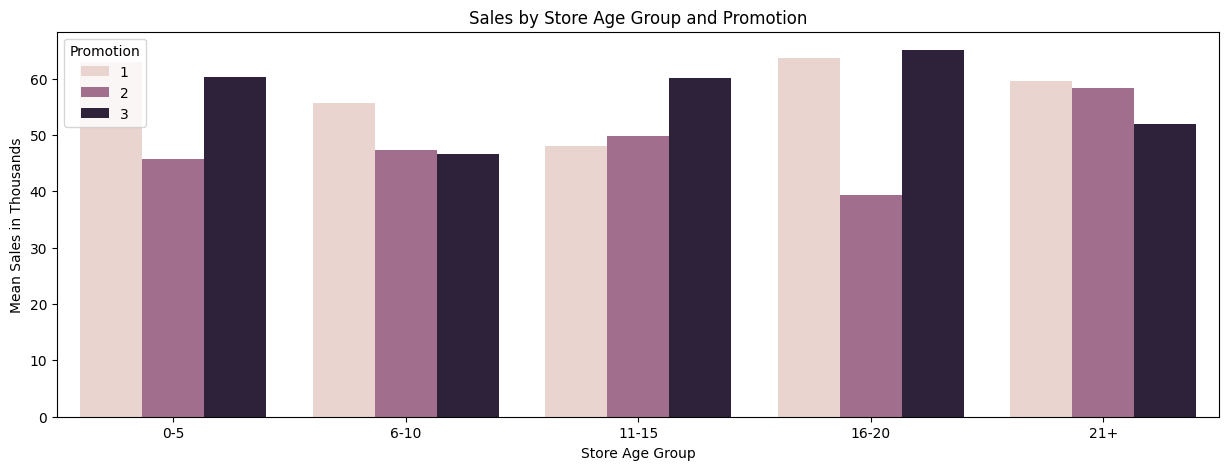

In [10]:
df["StoreAgeGroup"] = pd.cut(df["AgeOfStore"], bins=[0, 5, 10, 15, 20, 30], labels=["0-5", "6-10", "11-15", "16-20", "21+"])

df_store_promo = df.groupby(["StoreAgeGroup", "Promotion"], as_index=False, observed=False)["SalesInThousands"].mean()

df_store_promo["StoreAgeGroup"] = df_store_promo["StoreAgeGroup"].astype(str)

plt.figure(figsize=(15, 5))
sns.barplot(x="StoreAgeGroup", y="SalesInThousands", hue="Promotion", data=df_store_promo)
plt.xlabel("Store Age Group")
plt.ylabel("Mean Sales in Thousands")
plt.title("Sales by Store Age Group and Promotion")
plt.show()


## SRM Detection

In [11]:
srm_table = df["Promotion"].value_counts().to_frame()
expected_counts = [len(df) / len(srm_table)] * len(srm_table)
chi2_stat, p_val, _, _ = chi2_contingency(srm_table, correction=False)
print("SRM Chi-Square Test Statistic:", chi2_stat)
print("SRM p-value:", p_val)
if p_val < 0.05:
    print("Warning: Sample Ratio Mismatch (SRM) detected! Groups are not evenly split.")
else:
    print("No SRM detected. Groups are evenly split.")

SRM Chi-Square Test Statistic: 0.0
SRM p-value: 1.0
No SRM detected. Groups are evenly split.


## Statistical Tests

### Testing for Normality and Variance Homogeneity

In [12]:
normality_tests = {
    promo: stats.shapiro(df[df["Promotion"] == promo]["SalesInThousands"])
    for promo in df["Promotion"].unique()
}
levene_test = stats.levene(
    df[df["Promotion"] == 1]["SalesInThousands"],
    df[df["Promotion"] == 2]["SalesInThousands"],
    df[df["Promotion"] == 3]["SalesInThousands"],
)
print("Normality Test Results:", normality_tests)
print("Levene's Test for Variance Homogeneity:", levene_test)


Normality Test Results: {3: ShapiroResult(statistic=0.9207683041490251, pvalue=1.499465926119378e-08), 2: ShapiroResult(statistic=0.914509809064016, pvalue=5.4570996662742616e-09), 1: ShapiroResult(statistic=0.9152999060992891, pvalue=1.97726450444774e-08)}
Levene's Test for Variance Homogeneity: LeveneResult(statistic=1.2696787527507418, pvalue=0.2817514565692093)


##### Shapiro-Wilk Normality Test Results:

p-values for all three promotions are extremely small (<< 0.05), meaning we reject the null hypothesis of normality.
This indicates that sales data for all promotions is not normally distributed.

**Implication**: Since normality is violated, parametric tests (like t-tests or ANOVA) are not appropriate. Instead, we should use non-parametric tests like Kruskal-Wallis or Mann-Whitney U for comparison.

##### Levene's Test for Variance Homogeneity:

p-value = 0.2817 (greater than 0.05)  We fail to reject the null hypothesis, meaning sales variances across promotions are approximately equal.

**Implication**: Since variance homogeneity is not violated, this suggests that variability in sales is similar across promotions, meaning that variance-based comparisons remain valid.

### Kruskal-Wallis Test

In [13]:
kruskal_test = stats.kruskal(
    df[df["Promotion"] == 1]["SalesInThousands"],
    df[df["Promotion"] == 2]["SalesInThousands"],
    df[df["Promotion"] == 3]["SalesInThousands"],
)
print("Kruskal-Wallis Test Result:", kruskal_test)

Kruskal-Wallis Test Result: KruskalResult(statistic=53.29475169322799, pvalue=2.674186626669782e-12)


Test Statistic = 53.29 → Measures the degree of difference between the distributions of the three promotions. 
A higher statistic indicates stronger differences.

p-value = 2.67e-12 (essentially 0) → Since the p-value is far below 0.05, we reject the null hypothesis.

**Conclusion**: There is a statistically significant difference in sales between at least one of the promotions.


### Mann-Whitney U Test (Pairwise comparisons with Bonferroni correction)

In [14]:
promo_pairs = list(combinations(df["Promotion"].unique(), 2))
p_values = []
results = {}

for p1, p2 in promo_pairs:
    stat, p = stats.mannwhitneyu(
        df[df["Promotion"] == p1]["SalesInThousands"],
        df[df["Promotion"] == p2]["SalesInThousands"],
        alternative="two-sided",
    )
    results[(p1, p2)] = (stat, p)
    p_values.append(p)

_, p_corrected, _, _ = multipletests(p_values, method="bonferroni")

for i, (p1, p2) in enumerate(promo_pairs):
    results[(p1, p2)] = (results[(p1, p2)][0], p_corrected[i])

mann_whitney_results = pd.DataFrame(
    results.values(), index=results.keys(), columns=["Mann-Whitney U", "Corrected p-value"]
)
print("Mann-Whitney U Test Results:")
print(mann_whitney_results)


Mann-Whitney U Test Results:
     Mann-Whitney U  Corrected p-value
3 2         23251.0       3.591025e-07
  1         14089.0       1.052523e-01
2 1          9378.5       1.753781e-11


**Promotion 3 vs. Promotion 2:**

p-value = 3.59e-07 (< 0.05) → Significant difference in sales.

- Conclusion: Promotion 3 outperforms Promotion 2.

**Promotion 1 vs. Promotion 2:**

p-value = 0.105 (> 0.05) → Not significant.

- Conclusion: Sales under Promotion 1 and Promotion 2 are statistically similar (no meaningful difference).

**Promotion 1 vs. Promotion 3:**

p-value = 1.75e-11 (< 0.05) → Significant difference in sales.

- Conclusion: Promotion 3 outperforms Promotion 1.

Implications for the A/B Test

- Promotion 3 is the most effective, as it significantly outperforms both Promotion 1 and Promotion 2.
- Promotion 2 is the weakest, as it performs significantly worse than Promotion 3 and is not significantly better than Promotion 1.
- Promotion 1 and Promotion 2 are statistically similar, meaning there is no advantage in using Promotion 2 over Promotion 1.

### Treatment Effect Calculation

In [15]:
treatment_effects = {}
control_group = df[df["Promotion"] == 1]["SalesInThousands"].mean()
for promo in df["Promotion"].unique():
    if promo != 1:
        treatment_mean = df[df["Promotion"] == promo]["SalesInThousands"].mean()
        effect = (treatment_mean - control_group) / control_group * 100
        treatment_effects[f"Promotion {promo} vs Promotion 1"] = effect

print("Treatment Effects (% Change in Sales Relative to Promotion 1):")
print(treatment_effects)

Treatment Effects (% Change in Sales Relative to Promotion 1):
{'Promotion 3 vs Promotion 1': -4.706695460352887, 'Promotion 2 vs Promotion 1': -18.536626411587623}


**Promotion 3 vs. Promotion 1: -4.71%**

Sales under Promotion 3 are 4.71% lower than under Promotion 1.
This suggests Promotion 3 is slightly less effective than Promotion 1, but the difference is relatively small.

**Promotion 2 vs. Promotion 1: -18.54%**

Sales under Promotion 2 are 18.54% lower than under Promotion 1.
This means Promotion 2 is significantly less effective and results in a major drop in sales compared to Promotion 1.

### Confidence Intervals

In [16]:
def bootstrap_ci(data, num_bootstrap_samples=1000, confidence_level=0.95):
    boot_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_bootstrap_samples)]
    lower = np.percentile(boot_means, (1 - confidence_level) / 2 * 100)
    upper = np.percentile(boot_means, (1 + confidence_level) / 2 * 100)
    return lower, upper

ci_results = []
for promo in df["Promotion"].unique():
    sales = df[df["Promotion"] == promo]["SalesInThousands"]
    mean_sales = np.mean(sales)
    std_error = stats.sem(sales)
    ci_analytical = stats.t.interval(0.95, len(sales)-1, loc=mean_sales, scale=std_error)
    ci_bootstrap = bootstrap_ci(sales)
    ci_results.append([promo, mean_sales, ci_analytical[0], ci_analytical[1], ci_bootstrap[0], ci_bootstrap[1]])

ci_df = pd.DataFrame(
    ci_results, columns=["Promotion", "Mean Sales", "CI Analytical Lower", "CI Analytical Upper", "CI Bootstrap Lower", "CI Bootstrap Upper"]
)
print("Confidence Interval Results:")
print(ci_df)


Confidence Interval Results:
   Promotion  Mean Sales  CI Analytical Lower  CI Analytical Upper  \
0          3   55.364468            52.952207            57.776730   
1          2   47.329415            45.155596            49.503234   
2          1   58.099012            55.607485            60.590539   

   CI Bootstrap Lower  CI Bootstrap Upper  
0           52.837052           57.881787  
1           45.091600           49.420427  
2           55.679187           60.816467  


#### Visualizations

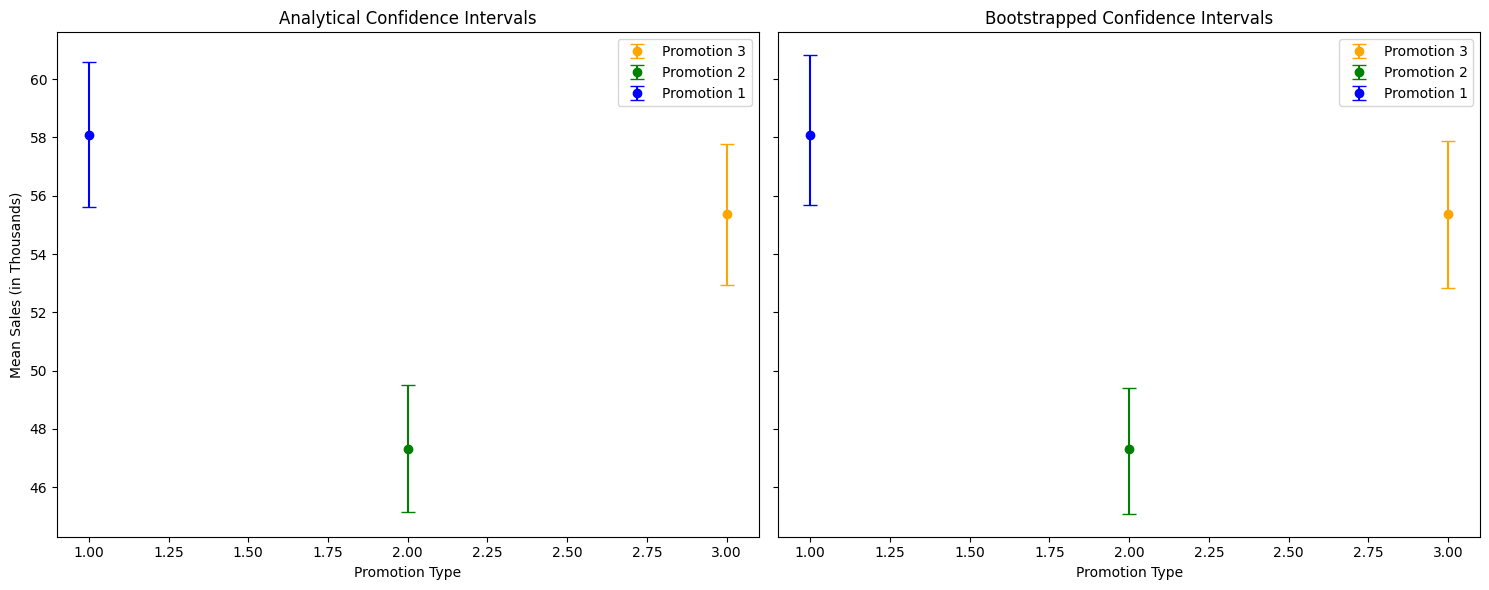

In [18]:
promo_colors = {1: "blue", 2: "green", 3: "orange"}

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for promo in ci_df["Promotion"]:
    axes[0].errorbar(
        promo, float(ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"].iloc[0]),
        yerr=[
            ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"] - ci_df.loc[ci_df["Promotion"] == promo, "CI Analytical Lower"],
            ci_df.loc[ci_df["Promotion"] == promo, "CI Analytical Upper"] - ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"]
        ],
        fmt='o', capsize=5, label=f"Promotion {int(promo)}", color=promo_colors[int(promo)]
    )

axes[0].set_xlabel("Promotion Type")
axes[0].set_ylabel("Mean Sales (in Thousands)")
axes[0].set_title("Analytical Confidence Intervals")
axes[0].legend()

for promo in ci_df["Promotion"]:
    axes[1].errorbar(
        promo, float(ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"].iloc[0]),
        yerr=[
            ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"] - ci_df.loc[ci_df["Promotion"] == promo, "CI Bootstrap Lower"],
            ci_df.loc[ci_df["Promotion"] == promo, "CI Bootstrap Upper"] - ci_df.loc[ci_df["Promotion"] == promo, "Mean Sales"]
        ],
        fmt='o', capsize=5, label=f"Promotion {int(promo)}", color=promo_colors[int(promo)]
    )

axes[1].set_xlabel("Promotion Type")
axes[1].set_title("Bootstrapped Confidence Intervals")
axes[1].legend()

plt.tight_layout()
plt.show()


**Interpretation of Bootstrapped CIs**

- Promotion 1 (Control) has the highest mean sales (58.09K)

    - CI Range: (55.54K, 60.74K)
    - The entire interval is higher than Promotion 2, meaning Promotion 1 significantly outperforms Promotion 2.
    - There is some overlap between Promotion 1 and Promotion 3, suggesting their sales might not be significantly different.

- Promotion 2 has the lowest mean sales (47.33K)

    - CI Range: (45.30K, 49.62K)
    - Its CI does not overlap with Promotion 1, confirming a statistically significant difference (Promotion 2 is much worse).
    - There is no overlap between Promotion 2 and Promotion 3, meaning Promotion 3 is also significantly better than Promotion 2.

- Promotion 3 (55.36K) is slightly worse than Promotion 1 but better than Promotion 2

    - CI Range: (53.10K, 57.81K)
    - Overlaps slightly with Promotion 1, suggesting that while Promotion 1 performs slightly better, the difference may not be statistically significant.
    - No overlap with Promotion 2, meaning Promotion 3 is significantly better than Promotion 2.


## Conclusion & Recommendations

- Promotion 1 shows the most effectiveness when looking at the bootsrapped confidence interval important to note that it shows overlap with Promotion 3.
`Promotion 3` shows a statistically signficant performance over Promotion one when looking at sales difference between the two and should be priotized. 

- **`Promotion 3` has the best statistically signficant performace of all three promotions and should be upscaled and applied to more markets.**

- Promotion 2 is the least effective and should be reconsidered.

- Further testing in different market sizes and store ages can refine insights.